# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


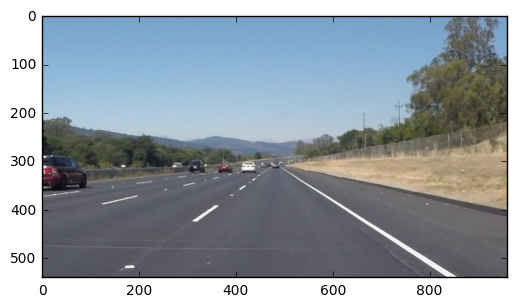

In [3]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [4]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    if lines is None:
        lines = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [9]:
import os
os.listdir("test_images/")

['.DS_Store',
 'challenge_light_cement.jpg',
 'challenge_light_cement_out.jpg',
 'challenge_shadows.jpg',
 'challenge_shadows_out.jpg',
 'solidWhiteCurve.jpg',
 'solidWhiteCurve_out.jpg',
 'solidWhiteRight.jpg',
 'solidWhiteRight_out.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowCurve2_out.jpg',
 'solidYellowCurve_out.jpg',
 'solidYellowLeft.jpg',
 'solidYellowLeft_out.jpg',
 'whiteCarLaneSwitch.jpg',
 'whiteCarLaneSwitch_out.jpg']

run your solution on all test_images and make copies into the test_images directory).

Median of [1,2,3,4,5] is 3


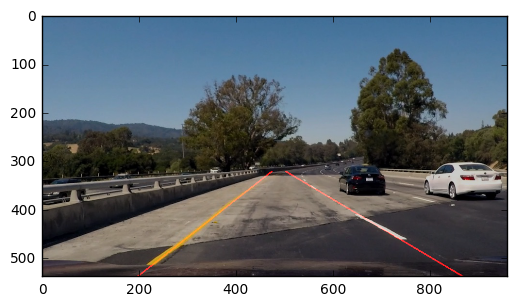

In [33]:
img_names = ['solidWhiteCurve', 'solidWhiteRight', 'solidYellowCurve',
             'solidYellowCurve2', 'solidYellowLeft', 'whiteCarLaneSwitch',
             'challenge_shadows', 'challenge_light_cement']

def median(items, value=(lambda x: x), weight=(lambda x: 1.0)):
    pairs = [[value(x),weight(x)] for x in sorted(items,key=value)]
    total_weight = sum([x[1] for x in pairs])
    half_weight = total_weight * 0.5
    weight_so_far = 0.0
    for pair in pairs:
        weight_so_far = weight_so_far + pair[1]
        if weight_so_far > half_weight:
            return pair[0]
    return None

def unnest_lines(lines):
    result = []
    for [[x1,y1,x2,y2]] in lines:
        result.append([x1,y1,x2,y2])
    return result

def nest_lines(lines):
    result = []
    for [x1,y1,x2,y2] in lines:
        result.append([[x1,y1,x2,y2]])
    return result

def filter_verticalish(lines):
    result = []
    for line in lines:
        x1,y1,x2,y2 = line
        if abs(x1-x2) < 2*abs(y1-y2):
            result.append(line)
    return result

def line_center(line):
    return [0.5*(line[0]+line[2]),0.5*(line[1]+line[3])]

def line_length(line):
    return ((line[0]-line[2])**2.0 + (line[1]-line[3])**2.0)**0.5

def filter_left_right(lines,xcenter):
    left = []
    right = []
    for line in lines:
        if line_center(line)[0] < xcenter:
            left.append(line)
        else:
            right.append(line)
    return left,right

def inverse_slope(line):
    deltax = line[0] - line[2]
    deltay = line[1] - line[3]
    return deltax * 1.0 / deltay

def x_intercept(point,inverse_slope):
    return point[0] - inverse_slope * point[1]

def median_inverse_slope(lines):
    return median(lines,value=inverse_slope,weight=line_length)

def median_line(lines,ymin,ymax):
    minv = median_inverse_slope(lines)
    xo = median(lines, value=(lambda x: x_intercept(x,minv)), weight=line_length)
    return [int(xo + ymin*minv), ymin, int(xo + ymax*minv), ymax]

def edge_lines_to_lane_lines(lines,xmin,ymin,xmax,ymax):
    lines = unnest_lines(lines)
    lines = filter_verticalish(lines)
    left,right = filter_left_right(lines, 0.5*(xmin+xmax))
    lines = []
    if len(left) > 0:
        lines.append(median_line(left,ymin,ymax))
    if len(right) > 0:
        lines.append(median_line(right,ymin,ymax))
    return nest_lines(lines)

def xform_img(img):
    original = img
    
    b,g,r = cv2.split(img)
    
    img = grayscale(img)
    img = gaussian_blur(img,5)
    img = canny(img,50,150)
    
    for channel in [b,g,r]:
        channel = gaussian_blur(channel,5)
        channel = canny(channel,50,150)
        img = weighted_img(img, channel, 1., 1.)
    
    top = 0
    bottom = img.shape[0]
    left = 0
    right = img.shape[1]
    horizon = int(0.4 * top + 0.6 * bottom)
    width = right - left
    xcenter = (left + right) / 2
    
    vertices = [(left,bottom),
                (xcenter - width / 30, horizon),
                (xcenter + width / 30, horizon),
                (right, bottom)]
    
    img = region_of_interest(img, np.int32(np.array([vertices])))
    
    rho = 2
    theta = 1*np.pi/180
    threshold = 15
    min_line_len = 40
    max_line_gap = 40
    
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    lanes = edge_lines_to_lane_lines(lines,xmin=left,ymin=horizon,xmax=right,ymax=bottom)
    img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(img, lanes)
    
    img = weighted_img(img, original)
    
    return img

for img_name in img_names:
    img = mpimg.imread('test_images/' + img_name + '.jpg')
    transformed = xform_img(img)
    mpimg.imsave('test_images/' + img_name + '_out.jpg', transformed, cmap='gray')
    plt.imshow(transformed,cmap='gray')

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [7]:
# Run once to install ffmpeg
import imageio
imageio.plugins.ffmpeg.download()

Imageio: 'ffmpeg.osx' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg.osx (28.8 MB)
Downloading: 8192/30241064 bytes (0.0%)40960/30241064 bytes (0.1%)237568/30241064 bytes (0.8%)516096/30241064 bytes (1.7%)811008/30241064 bytes (2.7%)1105920/30241064 bytes (3.7%)1630208/30241064 bytes (5.4%)1925120/30241064 bytes (6.4%)2220032/30241064 bytes (7.3%)2514944/30241064 bytes (8.3%)2826240/30241064 bytes (9.3%)3121152/30241064 bytes (10.3%)3235840/30241064 bytes (10.7%)3727360/30241064 bytes (12.3%)4022272

In [34]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [35]:
def process_image(img):
    return xform_img(img)

Let's try the one with the solid white lane on the right first ...

In [36]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:09<00:00, 23.40it/s]     | 3/222 [00:00<00:10, 21.05it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 9.42 s, sys: 279 ms, total: 9.7 s
Wall time: 9.79 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [37]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [38]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:30<00:00, 22.32it/s]     | 3/682 [00:00<00:30, 21.96it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 30.1 s, sys: 889 ms, total: 31 s
Wall time: 30.8 s


In [40]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

The image processing pipeline started out similar to the lane finding quiz: grayscale, gaussian blur, canny edge detection, masking, hough transform...

That approach worked well on most examples, but failed on the challenge video. Shadows from roadside trees were misinterpreted as lane lines. The hood of the car was misidentified as a lane line. A lane line on a lighter section of road was not detected. Even rough areas of the road were misidentified as lane lines. I took screenshots of a few key frames from the challenge video and began tuning the algorithm to handle these situations.

The simplest improvement was to filter out horizontal lines. Lane lines are close to vertical. Many of the false positives were close to horizontal, such as tree shadows, the bumper of the car, and changes in road material. I filtered out any lines with slope less than 1/3.

A lane line was not detected on a lighter section of the road. This lane line was almost invisible on a grayscale image but very clear on a color image. I decided to address this by creating four different versions of the grayscale image. One version (as usual) was based on brightness. The others represented the individual color channels: red, green, and blue. I applied canny edge detection to each of these four images then combined these into one image representing all edges. The result was edge detection that worked not just on changes in brightness, but also changes in color.

Those improvements greatly reduced the number of false positives, but did not eliminate them. Each frame still had a few edges that were not part of a lane line. The next improvement was essentially a voting process. If 80% of the detected lines were on a lane line, then they could outvote the 20% that represented false positives. I divided lines up between the left and right sides (based on line centers) and created one line on each side to represent all identified lines on that side. My approach was essentially a weighted median. I started out by finding the median slope of all lines on one side, with each line weighted based on its length. Then I calculated the x-intercepts that would be found by drawing lines with that slope through all line centers (again weighting by line length). I used the resulting slope and intercept to draw one line on each side from the bottom of the screen to the horizon (40% from the bottom).

With those improvements, the algorithm worked great on the challenge video, making mistakes on only a few of the 200+ frames in the video.

If I were to continue working on this project, the next step would be to extract the few frames from the challenge video that are still not handled correctly and investigate what went wrong. I would comment out parts of the pipeline to see the intermediate results and determine which step went wrong.

More broadly, the overall approach in this project assumes that the car is already well centered in its lane, that the lane lines are relatively straight (not on a sharp turn), and that the lane lines are visible (no snow or flooding). Changing any of these three conditions would require substantial changes to the approach. A better approach is to treat this as a localization problem, in which lane lines are just one of many indicators regarding the car's position and orientation within a road.

## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [41]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:21<00:00, 11.56it/s]     | 2/251 [00:00<00:22, 11.23it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 21.1 s, sys: 1.28 s, total: 22.4 s
Wall time: 22.4 s


In [42]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))